In [1]:
!pip3 install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch
from torch import tensor
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:

def get_device():
    """Returns the best available device for PyTorch."""

    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")

    return torch.device("cpu")

# Get the device to use
device = get_device()

In [4]:
device

device(type='cpu')

In [5]:
root_data_dir = "../TrainingDataset/"

In [6]:
segmented_data_dir = "../CroppedDataset/"

In [7]:
!cd .. && mkdir SegmentedDataset

mkdir: SegmentedDataset: File exists


# Loading Dataset

In [8]:
transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])
total_dataset = datasets.ImageFolder(root_data_dir, transform)

torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])
torch.Size([224, 224, 3])


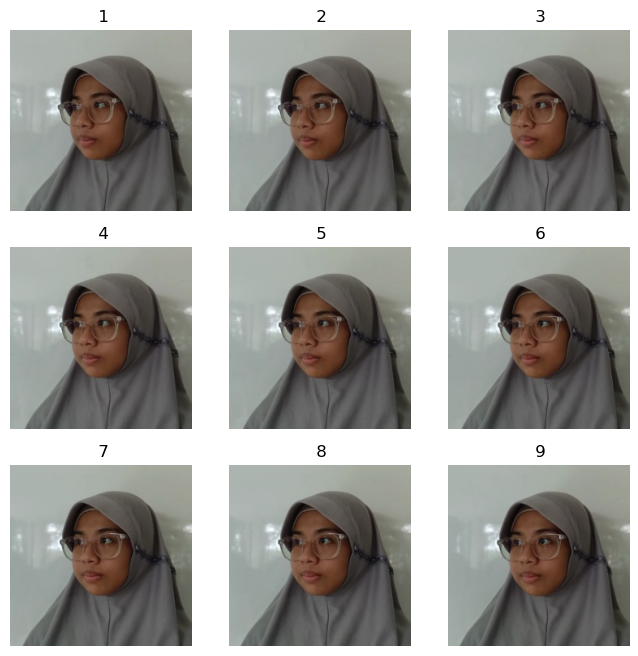

In [9]:
figure = plt.figure(figsize=(8,8))
cols, rows = 3,3

for i in range(1, cols * rows + 1):
    sample_idx = i
    img, label = total_dataset[sample_idx]
    img.to(device)
    img = img.transpose(0, 2)
    print(img.shape)
    img = img.transpose(1,0)
    figure.add_subplot(rows, cols, i)
#     print(labels.iloc[label].char)
    plt.title(f" {i}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [10]:
classes = total_dataset.classes
num_classes = len(classes)

# Face Recognition Cropping

In [11]:
from PIL import Image, ImageDraw, ImageFont
from facenet_pytorch import MTCNN

In [12]:
mtcnn = MTCNN(keep_all=True)

In [13]:
total_dataset[0]

(tensor([[[0.6706, 0.6706, 0.6706,  ..., 0.6510, 0.6471, 0.6471],
          [0.6706, 0.6706, 0.6706,  ..., 0.6510, 0.6471, 0.6471],
          [0.6627, 0.6627, 0.6667,  ..., 0.6510, 0.6471, 0.6471],
          ...,
          [0.6078, 0.6078, 0.6078,  ..., 0.3137, 0.3137, 0.3098],
          [0.6078, 0.6078, 0.6078,  ..., 0.3216, 0.3216, 0.3137],
          [0.6078, 0.6078, 0.6078,  ..., 0.3216, 0.3216, 0.3137]],
 
         [[0.6980, 0.6980, 0.6980,  ..., 0.6588, 0.6549, 0.6549],
          [0.6980, 0.6980, 0.6980,  ..., 0.6588, 0.6549, 0.6549],
          [0.6902, 0.6902, 0.6941,  ..., 0.6588, 0.6549, 0.6549],
          ...,
          [0.6353, 0.6353, 0.6353,  ..., 0.3216, 0.3255, 0.3216],
          [0.6353, 0.6353, 0.6353,  ..., 0.3216, 0.3216, 0.3137],
          [0.6353, 0.6353, 0.6353,  ..., 0.3216, 0.3216, 0.3137]],
 
         [[0.6706, 0.6706, 0.6706,  ..., 0.6157, 0.6118, 0.6118],
          [0.6706, 0.6706, 0.6706,  ..., 0.6157, 0.6118, 0.6118],
          [0.6627, 0.6627, 0.6667,  ...,

In [14]:
for X, y in total_dataset:
    all_boxes = mtcnn.detect(img)

    # Check if MTCNN detect good faces
    good_boxes = []
    for index, proba in enumerate(all_boxes[1]):
        print(proba)
        if(proba is not None and proba > 0.9):
            good_boxes.append(all_boxes[0][index])
    break

None


In [15]:
device

device(type='cpu')

In [16]:
segmented_data_dir

'../CroppedDataset/'

/Users/aldhanekaaai/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


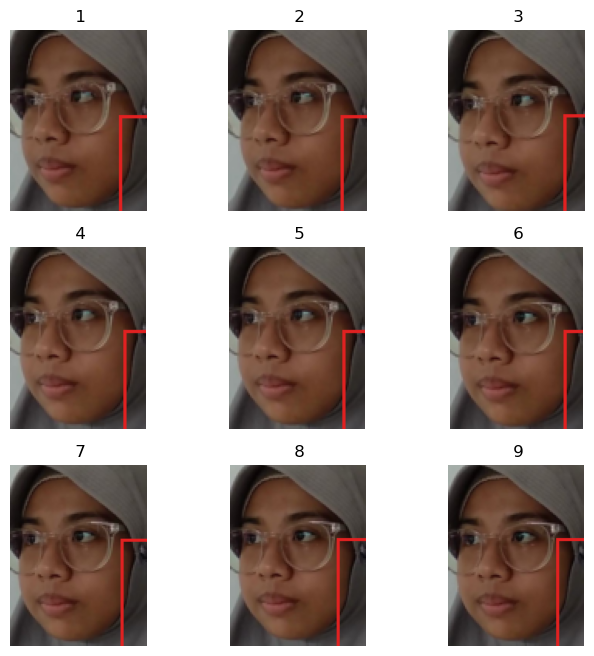

In [17]:
figure = plt.figure(figsize=(8,8))
cols, rows = 3,3
mtcnn = MTCNN(keep_all=True, device=device)

lastLabel = -1
j = -1
for i in range(1, cols * rows + 1):
    j += 1
    img_tensor, label = total_dataset[i]
    
    if lastLabel != label:
        os.makedirs(f"{segmented_data_dir}{classes[label]}/", exist_ok=True)
        j = 0
    
    lastLabel = label
    img_tensor.to(device)
    
    to_pil = transforms.ToPILImage()
    img = to_pil(img_tensor)
    
    all_boxes = mtcnn.detect(img)
    # print(all_boxes)
    
    good_boxes = []
    for index, proba in enumerate(all_boxes[1]):
        # print(proba)
        if(proba is not None and proba > 0.9):
            good_boxes.append(all_boxes[0][index])
            
    for boxes in good_boxes:
        # print(boxes)
        # print(boxes)
        
        img_result = img.crop(boxes) # to see the cropped
        
        img_cropped = transforms.functional.crop(img=img,top=boxes[1], left=boxes[0], width=(boxes[2]-boxes[0]), height=(boxes[3]-boxes[1]))

        transform = transforms.Compose([transforms.ToTensor(),transforms.Grayscale(), transforms.Resize((224, 224))])
        img_tensor = transform(img_cropped)
        save_image(img_tensor, f"{segmented_data_dir}{classes[label]}/{classes[label]}-{i}.jpg")
        # print(classes[label])

        emotion_color = (225,33,33)

        left, top, right, bottom = boxes
        x, y = left+5, bottom+2.5
    
        draw = ImageDraw.Draw(img_result)
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], width=2, outline=emotion_color)
    
    # img = img.transpose(1,0)
    figure.add_subplot(rows, cols, i)
#     print(labels.iloc[label].char)
    plt.title(f" {i}")
    plt.axis("off")
    plt.imshow(img_result, cmap="gray")
plt.show()

In [18]:
img = Image.open("TN Students Face Recognition (1)..jpg").convert('RGB')

In [19]:
img.size

(224, 224)

In [20]:
all_boxes = mtcnn.detect(img)
print(all_boxes)

(array([[68.4891128540039, 55.53813171386719, 143.9737548828125,
        158.16915893554688]], dtype=object), array([0.9969334602355957], dtype=object))


## Generating Crop Faces

In [21]:
for i in range(len(total_dataset)):
    print(i)
    break

0


In [22]:
os.makedirs(f"{segmented_data_dir}", exist_ok=True)

In [28]:
transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])
total_dataset = datasets.ImageFolder(root_data_dir, transform)

In [30]:

mtcnn = MTCNN(keep_all=True, device=device)

lastLabel = -1
j = -1
person_images = 0
person_invalid_images = 0
for i in range(len(total_dataset)):
    j += 1
    person_images += 1
    img_tensor, label = total_dataset[i]
    
    if lastLabel != label:
        if lastLabel != -1:
            print(f"Cropping {classes[label-1]}")
            print(f"Valid Images {person_images-person_invalid_images} of {person_images}")
            print(f"Valid Percentage {(person_images-person_invalid_images)/person_images}")
        person_images = 0
        person_invalid_images = 0
        
        os.makedirs(f"{segmented_data_dir}{classes[label]}/", exist_ok=True)
        j = 0
    
    lastLabel = label
    img_tensor.to(device)
    
    to_pil = transforms.ToPILImage()
    img = to_pil(img_tensor)
    
    all_boxes = mtcnn.detect(img)
    # print(all_boxes)
    
    good_boxes = []
    for index, proba in enumerate(all_boxes[1]):
        if(proba is not None and proba > 0.8):
            good_boxes.append(all_boxes[0][index])
        else:
            person_invalid_images += 1
            
    for boxes in good_boxes:
        # print(boxes)
        # print(boxes)
        
        img_result = img.crop(boxes) # to see the cropped
        
        img_cropped = transforms.functional.crop(img=img,top=boxes[1], left=boxes[0], width=(boxes[2]-boxes[0]), height=(boxes[3]-boxes[1]))

        transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((224, 224))])
        img_tensor = transform(img_cropped)
        save_image(img_tensor, f"{segmented_data_dir}{classes[label]}/{classes[label]}-{j}.jpg")
        # print(classes[label])

print("Finished!")

Cropping 10_Alifa
Valid Images 83 of 83
Valid Percentage 1.0
Cropping 11_Halim
Valid Images 80 of 83
Valid Percentage 0.963855421686747
Cropping 14_Altaf
Valid Images 83 of 83
Valid Percentage 1.0
Cropping 18_Fatih
Valid Images 84 of 84
Valid Percentage 1.0
Cropping 1_Aldhan
Valid Images 83 of 83
Valid Percentage 1.0
Cropping 22_Hafiz
Valid Images 84 of 84
Valid Percentage 1.0
Cropping 28_Alaikal
Valid Images 106 of 106
Valid Percentage 1.0
Cropping 3_Dzaki
Valid Images 83 of 83
Valid Percentage 1.0
Finished!
